# Monte Carlo

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="cart_pole.gif" width="400">

Objetivo: usar o controle de Monte Carlo de primeira visita on-policy ($\varepsilon$-soft) para estimar uma política $\pi \approx \pi_*$ que controle um pêndulo invertido.

## Características do pêndulo:

### Espaço de observações

| Número | Observação | Min | Max |
| :- | -: | :-: | :-: |
| 0	| Posição do carrinho | -4.8 | 4.8|
| 1	| Velocidade do carrinho | $-\infty$ | $\infty$|
| 2	| Ângulo do pêndulo | -0.418 rad (-24°)	| 0.418 rad (24°)|
| 3	| Velocidade angular do pêndulo	| $-\infty$ | $\infty$ |

### Espaço de ações
| Número | Ação |
| :- | -: |
| 0	| Carrinho para a esquerda |
| 1	| Carrinho para a direita |

### Função de reforço

- Devolve +1 para cada passo antes do pêndulo cair.
- Episódio termina quando o ângulo do pêndulo excede ±12°, ou quando a posição do carrinho é maior que ±2.4.
- Máximo de 200 passos.

Importando bilbiotecas. A biblioteca gym emula ambientes para aprendizado por reforço (no caso, o pêndulo).

In [1]:
import numpy as np
import gym
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)
from IPython.display import clear_output
import seaborn as sns
sns.set()

Cria uma classe (```RunningAverage()```) apenas para calcular a média móvel do sinal de reforço.

In [2]:
##########################################
class RunningAverage(object):
    def __init__(self, N):
        self.N = N
        self.vals = []
        self.num_filled = 0

    def push(self, val):
        if self.num_filled == self.N:
            self.vals.pop(0)
            self.vals.append(val)
        else:
            self.vals.append(val)
            self.num_filled += 1

    def get(self):
        return float(sum(self.vals)) / self.num_filled

Criando a classe do Monte Carlo tabular. Nesse exemplo, vamos usar o pêndulo: ```gym.make('CartPole-v0')```.

In [3]:
class TabularMC():
    ##########################################
    def __init__(self, parameters):

        self.episode = 0

        # cria o ambiente (pendulo invertido)
        self.env = gym.make('CartPole-v0')
        num_states = [1, 8, 8, 8]
        lower_bounds = [-4.8, -3.0, -0.418, -2.0]
        upper_bounds = [ 4.8,  3.0,  0.418,  2.0]

        # converte estados continuos em discretos
        self.get_state = partial(self.obs_to_state, num_states, lower_bounds, upper_bounds)

        # tamanho dos espacos de estados e acoes
        self.num_states = np.prod(np.array(num_states))
        self.num_actions = self.env.action_space.n

        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.eps = parameters['eps']

        # reseta a politica
        self.reset_policy()

        # eh first-visit?
        self.first_visit = parameters['first-visit']

    ##########################################
    # reseta a funcao acao-valor
    def reset_policy(self):
        # Q(s,a)
        self.Q = np.zeros((self.num_states, self.num_actions))

        # Retornos(s,a)
        self.returns = [ [ [] for i in range(self.num_actions) ] for j in range(self.num_states) ]

    ##########################################
    # retorna a politica corrente
    def curr_policy(self, copy=False):
        if copy:
            return partial(self.TabularEpsilonGreedyPolicy, np.copy(self.Q))
        else:
            return partial(self.TabularEpsilonGreedyPolicy, self.Q)

    ##########################################
    # converte estados continuos em discretos
    def obs_to_state(self, num_states, lower_bounds, upper_bounds, obs):
        state_idx = []
        for ob, lower, upper, num in zip(obs, lower_bounds, upper_bounds, num_states):
            state_idx.append(self.discretize_val(ob, lower, upper, num))
        return np.ravel_multi_index(state_idx, num_states)

    ##########################################
    # discretiza um valor
    def discretize_val(self, val, min_val, max_val, num_states):
        state = int(num_states * (val - min_val) / (max_val - min_val))
        if state >= num_states:
            state = num_states - 1
        if state < 0:
            state = 0
        return state

    ##########################################
    def __del__(self):
        self.env.close()

Usando $\pi$ para gerar um episódio: $S_0$, $A_0$, $R_1$, $\ldots$, $S_{T-1}$, $A_{T-1}$, $R_T$.

In [4]:
class TabularMC(TabularMC):
    ##########################################
    # simula um episodio até o fim seguindo a politica corrente
    def oneEpisode(self, max_iter=10000, render=False):

        # inicia o ambiente (começa aleatoriamente)
        obs = self.env.reset()

        # listas da trajetoria S_{T-1}, A_{T-1}, R_{T}, ....
        rewards, actions, states = ([] for i in range(3))

        for _ in range(max_iter):
            # gera estados baseado na observacao
            S = self.get_state(obs)
            # \pi(s)
            A = self.policy(S)

            # renderiza o ambiente
            if render: self.env.render(mode='rgb_array')

            # passo de interacao com o ambiente
            [obs, R, done, info] = self.env.step(A)

            # Salva S_{T-1}, A_{T-1}, R_{T}, ....
            actions.append(A)
            states.append(S)
            rewards.append(R)

            # chegou a um estado terminal?
            if done: break

        return [states, actions, rewards]

Computa a função ação-valor $Q(S_t, A_t) \gets \textrm{média}(Retornos(S_t, A_t))$

In [5]:
class TabularMC(TabularMC):
    ##########################################
    def Iterate(self):

        # novo episodio
        self.episode += 1

        # pega a politica corrente (on-policy)
        self.policy = self.curr_policy()

        # gera um episodio seguindo a politica corrente
        [states, actions, rewards] = self.oneEpisode(render=(self.episode%10 == 0))

        # estados alcancados
        updated_states = set()

        G = 0.0
        # processa experiencia
        for state, action, reward in zip(states, actions, rewards):

            # first-visit?
            if self.first_visit:
                if state in updated_states:
                    continue
                updated_states.add(state)

            # atualiza Q(s,a)
            G = self.gamma*G + reward
            self.returns[state][action].append(G)
            
            # Q(S_t, A_t) \gets média(Retornos(S_t, A_t))
            self.Q[state, action] = np.mean(self.returns[state][action])

        return np.sum(np.array(rewards))

Probabilidade de escolha de uma ação $a$ baseada na política $\varepsilon$-soft:
$$
\pi(a|S_t) \gets 
                        \begin{cases}
                            1 - \varepsilon + \varepsilon/|\mathcal{A}|,  & \text{se}~ a = A^*,\\
                            \varepsilon/|\mathcal{A}|, & \text{caso contrário.}
                        \end{cases}
$$

In [6]:
class TabularMC(TabularMC):
    ##########################################
    # escolha da açao (epsilon-soft)
    def TabularEpsilonGreedyPolicy(self, Q, state):

        # acao otima corrente A*
        Aast = Q[state, :].argmax()

        # probabilidades de escolher as acoes
        p1 = 1.0 - self.eps + self.eps/self.num_actions
        p2 = self.eps/self.num_actions
        prob = [p1 if a == Aast else p2 for a in range(self.num_actions)]
        
        return np.random.choice(self.num_actions, p=np.array(prob))

Programa principal.

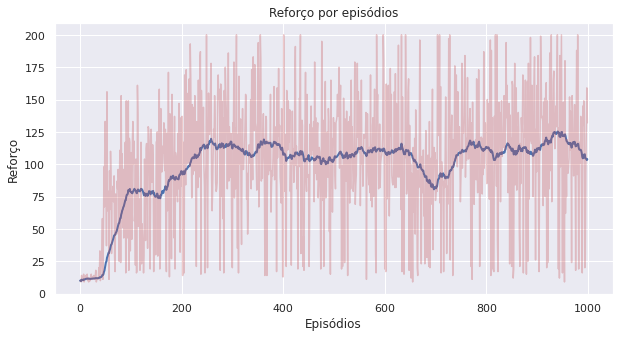

In [7]:
##########################################
# main
##########################################
if __name__ == '__main__':
    
    plt.ion()
    
    # cria objeto para calculo da média movel do reward
    avg_calc = RunningAverage(50)
    
    # parametros
    parameters = {'episodes'    : 1000,
                  'gamma'       : 1.0,
                  'eps'         : 1.0e-1,
                  'first-visit' : False}
    
    # Cria Monte-Carlo tabular
    mc = TabularMC(parameters)

    # historico dos reforços
    rewards = []
    avg_rewards = []

    # loop principal
    for _ in range(parameters['episodes']):
        
        # roda um episodio
        total_reward = mc.Iterate()
        
        # rewrds
        rewards.append(total_reward)
        # reward medio
        avg_calc.push(total_reward)
        avg_rewards.append(avg_calc.get())
        
        # plot
        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title('Reforço por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Reforço')
        plt.show()
        plt.pause(.1)

plt.ioff()